# Диагностика кожных заболеваний по фото

**Данные**: медицинские фотографии.

**Задача**: определение злокачественности образования по фотографии кожи пациента.

В этом ноутбуке предложено сравнение качества классификации злокачественности образований на реальном и синтетическом наборе данных.


*Синтетический набор данных производится путем генерации изображений с помощью модели условного вариационного автокодировшика (Conditional VAE).*

## Загрузка библиотек

In [ ]:
!pip install jupyter ipywidgets IProgress

In [ ]:
!pip install medmnist

In [ ]:
! pip install torchfusion

In [ ]:
from collections import Counter
from IPython.display import Image
from medmnist import INFO, Evaluator
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn, optim
from torch.distributions import Normal
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
from torchvision.transforms.transforms import Resize
from torchvision.utils import save_image
from tqdm import tqdm

import gc
import json
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import os
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils

import warnings
warnings.filterwarnings('ignore')

### Проверка доступности GPU

In [ ]:
def check_cuda_availability():
    """
    Checks whether CUDA is available.
    """
    print(
        torch.cuda.is_available(),",",
        torch.cuda.current_device(),",",
        torch.cuda.device(0),",",
        torch.cuda.device_count(),"\n",
        torch.cuda.get_device_name(0),
        sep=""
    )

# cuda setup
global device
device = torch.device("cuda")

In [ ]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7cc6e4226ce0>,1
Tesla T4


## Вспомогательные функции

In [ ]:
"""

This .py file contains the classes <CNN> and <classification>, and the
functions <print_accuracy_convergence>, <run_classifier_pipeline>
inspired in part from the notebook getting_started.ipynb found
in the /examples/ subfolder in:
    > https://github.com/MedMNIST/MedMNIST/

Citations:
    > Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke,
    > Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight
    > Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint
    > arXiv:2110.14795, 2021.
    >
    > Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon:
    > A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th
    > International Symposium on Biomedical Imaging (ISBI), 2021.

"""

##############################
########## CLASSES ###########
##############################

class CNN(nn.Module):
    """
    Defines a simple convolutional neural network with which to run
    simple binary or multi-class classification.
    """
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class classification():
    """
    Defines a machine learning classification pipeline using
    the CNN network previously declared.
    """
    def __init__(self, n_channels, n_classes, task, learning_rate, name):
        # Defines the pipeline model
        self.model = CNN(in_channels=n_channels, num_classes=n_classes).cuda()
        self.best_model = None
        self.data_flag = name
        # Defines the loss function and optimizer
        if task == "multi-label, binary-class":
            self.criterion = nn.BCEWithLogitsLoss()
        else:
            self.criterion = nn.CrossEntropyLoss()
        self.task = task
        self.optimizer = optim.SGD(self. model.parameters(),
                                   lr=learning_rate, momentum=0.9)
        # Creates a boolean check to avoid testing before training
        self.training_done=False
        # Defines a list holder for the epoch accuracies for each
        # epoch of a training process
        self.train_accuracy_per_epoch = []
        self.val_accuracy_per_epoch = []
        self.val_AUC_per_epoch = []
        self.best_val_accuracy = float("-inf")
        self.test_accuracy = None
        self.test_AUC = None
    def train(self, train_loader, val_loader, epochs=3):
        """
        Runs the training phase for the loaded model for a given
        data loader and a given number of epochs
        """
        train_accuracies = []
        for epoch in range(epochs):
            print(f"===================\nEpoch {epoch}\n")
            train_correct = 0
            train_total = 0
            self.model.train()
            for inputs, targets in tqdm(train_loader):
                # Performs the forward + backward + optimize passes
                self.optimizer.zero_grad()
                outputs = self.model(inputs.cuda())
                if self.task == "multi-label, binary-class":
                    targets = targets.to(torch.float32).cuda()
                else:
                    targets = targets.squeeze().long().cuda()
                loss = self.criterion(outputs, targets)
                loss.backward(retain_graph=True)
                self.optimizer.step()
                # Computes the batch results
                train_correct += sum(targets == torch.argmax(outputs, 1))
                train_total += len(outputs)
            # Computes the epoch accuracies
            acc = train_correct.item()/train_total
            self.train_accuracy_per_epoch.append(acc)
            print(f"train -- accuracy: {round(acc,4)}")
            val_acc, val_AUC = self.test(val_loader, split = "val")
            if val_acc > self.best_val_accuracy:
                self.best_val_accuracy = val_acc
                self.best_model = self.model.state_dict()
            self.val_accuracy_per_epoch.append(val_acc)
            self.val_AUC_per_epoch.append(val_AUC)
        # Records that the train phase was done
        self.training_done=True
        print("===================")
    def test(self, test_loader, label_names = None, split = "test",
             display_confusion_matrix=False, use_best_model=False):
        """
        Runs the test phase for the trained model.
        """
        if use_best_model:
            self.model.load_state_dict(self.best_model)
        self.model.eval()
        y_true = torch.tensor([]).cuda()
        y_score = torch.tensor([]).cuda()
        # Computes for the whole given data loader, the corresponding
        # accuracy with the previously trained model.
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = self.model(inputs.cuda())
                if self.task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32).cuda()
                    outputs = outputs.softmax(dim=-1)
                else:
                    targets = targets.squeeze().long().cuda()
                    outputs = outputs.softmax(dim=-1).cuda()
                    targets = targets.float().resize_(len(targets), 1)
                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)
            y_preds = torch.argmax(y_score, 1)
            y_true = y_true.detach().cpu().numpy()
            y_score = y_score.detach().cpu().numpy()
            evaluator = Evaluator(self.data_flag, split)
            metrics = evaluator.evaluate(y_score)
        accuracy = metrics[1]
        AUC = metrics[0]
        if display_confusion_matrix:
            print(f"{split} -- accuracy: {round(accuracy,4)}, ",
                  f"AUC: {round(AUC, 4)}")
            cm = confusion_matrix(y_true.tolist(),
                                  y_preds.tolist())
            if label_names is None:
                disp = ConfusionMatrixDisplay(
                    confusion_matrix=cm
                )
            else:
                disp = ConfusionMatrixDisplay(
                    confusion_matrix=cm,
                    display_labels=label_names
                )
            plt.figure(figsize=(10,10))
            disp.plot()
            plt.xticks(rotation=90)
            plt.show()
        else:
            print(f"{split} -- accuracy: {round(accuracy,4)}, ",
                  f"AUC: {round(AUC, 4)}")
        return accuracy, AUC

##############################
######### FUNCTIONS ##########
##############################

def print_accuracy_convergence(training_accs, validation_accs, validation_AUC, test_acc, test_AUC):
    """
    Prints the convergence plot of the training and validation losses.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(training_accs)
    plt.plot(validation_accs)
    plt.plot(validation_AUC)
    plt.plot(len(training_accs)-1,test_acc,'ro')
    plt.plot(len(training_accs)-1,test_AUC,'^')
    plt.title("Training & Validation Accuracy per Epoch")
    plt.legend(["Training Acc.", "Validation Acc.", "Validation AUC",
                "Test Acc. (model with best val. acc.)",
                "Test AUC (model with best val. acc.)"])
    plt.show()

def run_classifier_pipeline(name, info_flags, imported_data,
                            learning_rate=0.001, epochs=20
                            ):
    """
    Runs the training and testing process for the classifier
    declared above.
    """
    # Prints the description of the dataset
    info = info_flags[name][0]
    print(json.dumps(info, sort_keys=False, indent=2))
    # Declares the model
    clf = classification(
        n_channels=info["n_channels"],
        n_classes=len(info["label"]),
        task=len(info["task"]),
        learning_rate=learning_rate,
        name=name
    )
    print(summary(clf.model, input_size=(info["n_channels"], 28, 28)))
    # Runs the training phase
    clf.train(
        train_loader=imported_data[3],
        val_loader=imported_data[5],
        epochs=epochs
    )
    # Runs the testing phase
    clf.test_accuracy, clf.test_AUC = clf.test(
        test_loader=imported_data[4],
        label_names=info["label"].values(),
        display_confusion_matrix=True,
        use_best_model=True
    )
    print_accuracy_convergence(clf.train_accuracy_per_epoch, clf.val_accuracy_per_epoch,
                               clf.val_AUC_per_epoch, clf.test_accuracy, clf.test_AUC)
    if not os.path.exists("trained_models/classifier/"):
        os.makedirs("trained_models/classifier/")
    if name not in os.listdir("trained_models/classifier/"):
        os.makedirs(f"trained_models/classifier/{name}")
    # Saves the model
    torch.save(clf.model.state_dict(),
               f"trained_models/classifier/{name}/{name}_epochs{epochs}.pth")
    return clf

"""

This .py file contains the class <MyDataset>, and the functions
<check_cuda_availability>, <create_data_loaders>, <display_set_statistics>,
<generate_synthetic_dataset_condVAE>,
 <import_dataset>, <retrieve_flag_info>
adapted from the notebook getting_started found in the /examples/
subfolder in:
    > https://github.com/MedMNIST/MedMNIST/

Citations:
    > Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke,
    > Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight
    > Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint
    > arXiv:2110.14795, 2021.
    >
    > Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon:
    > A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th
    > International Symposium on Biomedical Imaging (ISBI), 2021.

"""

##############################
########## CLASSES ###########
##############################

class MyDataset(data.Dataset):
    """
    Custom Dataset class to allow for data transforms.
    """
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # Normalize your data here
        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

##############################
######### FUNCTIONS ##########
##############################

def check_cuda_availability():
    """
    Checks whether CUDA is available.
    """
    print(
        torch.cuda.is_available(),",",
        torch.cuda.current_device(),",",
        torch.cuda.device(0),",",
        torch.cuda.device_count(),"\n",
        torch.cuda.get_device_name(0),
        sep=""
    )

def create_data_loaders(DataClass,
                        batch_size, print_visualization,
                        validation_split=0.1, download=True):

    """
    Creates the train, train_at_eval (validation), and test
    data loaders of a given dataclass from the MedMNIST and returns
    them as a tuple.
    """
    # Declares the dataloader pre-processing
    data_transform_valtest = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])

    data_transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])
    # Loads the data
    train_dataset = DataClass(split="train",
                              transform=data_transform_train,
                              download=download)
    val_dataset = DataClass(split="val",
                              transform=data_transform_valtest,
                              download=download)
    test_dataset = DataClass(split="test",
                             transform=data_transform_valtest,
                             download=download)
    # Visualizes the imported data
    if print_visualization:
        print("===================")
        print("Montage of randomly extracted images from the dataset:")
        display(train_dataset.montage(length=10))

    # Encapsulates data into dataloader form
    train_loader = data.DataLoader(dataset=train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)
    val_loader = data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset,
                                  batch_size=batch_size,
                                  shuffle=False)
    # Prints the resulting loader metadata
    print("===================")
    ret = (train_dataset, test_dataset, val_dataset,
           train_loader, test_loader, val_loader)
    return ret

def display_set_statistics(datasets, dataset_info, name):
    """
    Given a Pytorch dataset object and its information object
    Computes the histogram of sample splits between the different
    dataset classes
    """
    true_labels_train = [entry[1][0] for entry in datasets[0]]
    true_labels_validation = [entry[1][0] for entry in datasets[1]]
    true_labels_test = [entry[1][0] for entry in datasets[2]]
    label_names = dataset_info[0]["label"]
    dataset_counter_train = Counter(true_labels_train).items()
    dataset_counter_validation = Counter(true_labels_validation).items()
    dataset_counter_test = Counter(true_labels_test).items()
    statistics_train = {label_names[f"{key}"]:value
                        for key,value in dataset_counter_train}
    statistics_validation = {label_names[f"{key}"]:value
                             for key,value in dataset_counter_validation}
    statistics_test = {label_names[f"{key}"]:value
                       for key,value in dataset_counter_test}
    plt.figure(figsize=(15,8))
    plt.subplot(1, 3, 1)
    plt.bar(statistics_train.keys(), statistics_train.values())
    plt.title(f"Label distribution in\nthe {name} training set")
    plt.xticks(rotation=90)
    plt.subplot(1, 3, 2)
    plt.bar(statistics_validation.keys(), statistics_validation.values())
    plt.title(f"Label distribution in\nthe {name} validation set")
    plt.xticks(rotation=90)
    plt.subplot(1, 3, 3)
    plt.bar(statistics_test.keys(), statistics_test.values())
    plt.title(f"Label distribution in\nthe {name} test set")
    plt.xticks(rotation=90)
    plt.show()

def generate_synthetic_dataset_condVAE(n_channels, n_classes, latent_dims,
                               model_path,
                               original_train_set, batch_size,
                               test_loader, val_loader, n_sampling=None,
                               weighted_sampling=False):
    """
    Generates a synthetic training set for a classifier task.
    """
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    # Loads conditional VAE model
    with torch.no_grad():
        model = ConditionalVAE(n_channels, n_classes, latent_dims).cuda()
        model.load_state_dict(torch.load(model_path))
        # Generates new images with their labels
        labels = np.random.randint(0, n_classes, n_sampling)
        images = model.sample(
            n_sampling,
            one_hot(torch.tensor(labels).int(),n_classes).cuda()
        ).detach().cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    # Generates the synthetic dataset
    #for entry in original_train_set:
    old_labels = np.array([x[0] for x in original_train_set.labels])
    new_dataset = data.TensorDataset(images, torch.Tensor(labels).int())

    train_loader = data.DataLoader(
            dataset=new_dataset,
            batch_size=batch_size,
            shuffle=True
        )
    return new_dataset, "", "", train_loader, test_loader, val_loader


def import_dataset(name, info_flags, batch_size=64, print_visualization=False):
    """
    Imports a given MedMNIST dataset and prints the population
    distribution for both train and test sets.
    """
    dataset = create_data_loaders(info_flags[name][4],
                                  batch_size=batch_size,
                                  print_visualization=print_visualization)
    if print_visualization:
        display_set_statistics(dataset, info_flags[name], name)
    return dataset

def retrieve_flag_info(flag):
    """
    Given a MedMNIST flag string, retrieves the related
    info, task, n_channels, n_classes, and DataClass.
    """
    info = INFO[flag]
    task = info["task"]
    n_channels = info["n_channels"]
    n_classes = len(info["label"])
    DataClass = getattr(medmnist, info["python_class"])
    return info, task, n_channels, n_classes, DataClass

"""

This .py file contains the function <run_GAN_pipeline>
inspired in part from the following repository:
    > https://github.com/imadtoubal/Conditional-DC-GAN-in-Pytorch

"""

##############################
######### FUNCTIONS ##########
##############################
"""

This .py file contains the classes <ConditionalVAE>, <TestCVAE>,
and the functions <one_hot>, <model_evaluate>, <model_train>,
<print_loss_convergence> and <run_encoder_pipeline> inspired in part from the
following repositories:
    > https://github.com/AntixK/PyTorch-VAE
    > https://github.com/unnir/cVAE

Citations:
    > Subramanian, A.K, PyTorch-VAE,2020,GitHub, GitHub repository

"""

##############################
########## CLASSES ###########
##############################

class ConditionalVAE(nn.Module):
    """
    Implementation of a Conditional Variational Autoencoder.
    """
    def __init__(self, in_channels, n_classes, latent_dims,
                 hidden_dims=[32, 64, 128, 256, 512], img_size=28):
        super(ConditionalVAE, self).__init__()
        # Records the dimensional parameters
        self.channel_size = in_channels
        self.class_size = n_classes
        self.latent_dimensions = latent_dims
        self.hidden_layer_dimensions = hidden_dims
        self.fc_factor = 4
        self.image_size = img_size
        # Declares the layers of the CVAE encoder (Convolutional + FC)
        in_channels += 1
        encoder_modules = []
        for dim in self.hidden_layer_dimensions:
            encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(dim),
                    nn.LeakyReLU()
                )
            )
            in_channels=dim
        # Declares the hidden layers of the CVAE decoder (Convolutional + FC)
        self.decoder_input = nn.Linear(
            latent_dims + n_classes,
            self.hidden_layer_dimensions[-1]*self.fc_factor
        )
        decoder_modules = []
        for layer in range(len(self.hidden_layer_dimensions)-1,0,-1):
            decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        self.hidden_layer_dimensions[layer],
                        self.hidden_layer_dimensions[layer-1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1
                    ),
                    nn.BatchNorm2d(self.hidden_layer_dimensions[layer-1]),
                    nn.LeakyReLU()
                )
            )
        # Declares the first layer of the decoder
        self.decoder_input_layer = nn.Linear(
            latent_dims + n_classes,
            self.hidden_layer_dimensions[-1]*self.fc_factor
        )
        # Declares the final layer of the decoder
        self.decoder_output_layer = nn.Sequential(
            nn.Sequential(
                nn.ConvTranspose2d(
                    self.hidden_layer_dimensions[0],
                    self.hidden_layer_dimensions[0],
                    kernel_size=3,
                    stride=2,
                    padding=2,
                    output_padding=0
                ),
                nn.BatchNorm2d(self.hidden_layer_dimensions[0]),
                nn.LeakyReLU(),
                nn.Conv2d(
                    self.hidden_layer_dimensions[0],
                    out_channels=self.hidden_layer_dimensions[0],
                    kernel_size=3,
                    padding=0,
                    stride=2,
                ),
                nn.BatchNorm2d(self.hidden_layer_dimensions[0]),
                nn.LeakyReLU(),
                nn.Conv2d(
                    self.hidden_layer_dimensions[0],
                    out_channels=self.channel_size,
                    kernel_size=3,
                    padding=0,
                    stride=1
                ),
                nn.Tanh()
            )
        )
        # Sets up the encoder and decoder
        self.encoder = nn.Sequential(*encoder_modules)
        self.decoder = nn.Sequential(*decoder_modules)
        self.fc_mu = nn.Linear(self.hidden_layer_dimensions[-1], latent_dims)
        self.fc_var = nn.Linear(self.hidden_layer_dimensions[-1], latent_dims)
        # Sets up the embedding input for the encoder
        self.class_embedding = nn.Linear(n_classes, img_size*img_size)
        self.data_embedding = nn.Conv2d(
            self.channel_size, self.channel_size, kernel_size=1
        )
    def decode(self, to_decode):
        """
        Decodes an input entry (z) by casting it up the decoder network
        declared at initialization.
        """
        decoding = self.decoder_input_layer(to_decode)
        decoding = decoding.view(-1, self.hidden_layer_dimensions[-1], 2, 2)
        decoding = self.decoder(decoding)
        decoding = self.decoder_output_layer(decoding)
        return decoding
    def encode(self, to_encode):
        """
        Encodes an input image by casting it down the encoder network
        declared at initialization.
        """
        encoding = self.encoder(to_encode)
        encoding = torch.flatten(encoding, start_dim=1)
        # Computes the mean and variance components of the variational autoencoder
        mu = self.fc_mu(encoding)
        var = self.fc_var(encoding)
        return mu, var
    def forward(self, x, y):
        """
        Performs a forward pass through the Conditional VAE
        """
        embedded_classes = self.class_embedding(y.float())
        embedded_classes = embedded_classes.view(
            -1,self.image_size,self.image_size
        ).unsqueeze(1)
        embedded_input = self.data_embedding(x)
        _x = torch.cat([embedded_input, embedded_classes], dim=1)
        mu, var = self.encode(_x)
        z = self.reparametrize(mu, var)
        z = torch.cat([z, y], dim=1)
        return self.decode(z), x, mu, var
    def generate(self, x, y):
        """
        Given an input image x, returns the reconstructed image.
        """
        return self.forward(x, y)[0]
    def loss_function(self, recons, x, mu, var):
        """
        Implementation of the Conditional VAE loss function based on the
        Kullback-Leibler divergence.
        """
        kld_weight = 0.005
        recons_loss = F.mse_loss(recons, x, reduction="sum")
        kld_loss = torch.mean(-0.5 * torch.sum(
            1 + var - mu ** 2 - var.exp(), dim = 1
        ), dim = 0)
        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    def reparametrize(self, mu, var):
        """
        Given a Gaussian latent space, provides a reparametrization factor
        """
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        return mu + eps*std
    def sample(self, num_samples, y):
        """
        Samples from the latent space and return the corresponding
        image space map.
        """
        z = torch.randn(num_samples, self.latent_dimensions)
        z = z.to(device)
        z = torch.cat([z, y.float()], dim=1)
        samples = self.decode(z)
        return samples



class TestCVAE():
    """
    Implementation of a Conditional Variational Autoencoder test.
    """
    def __init__(self, n_channels, n_classes, latent_dims):
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.latent_dims = latent_dims
        self.model = ConditionalVAE(n_channels, n_classes, latent_dims)
    def test_forward(self):
        x = torch.randn(10, self.n_channels, 28, 28)
        c = torch.randn(10, self.n_classes)
        y = self.model(x, c)
        print("Model Output size:", y[0].size())
        return True
    def test_loss(self):
        x = torch.randn(10, self.n_channels, 28, 28)
        c = torch.randn(10, self.n_classes)
        result = self.model(x, c)
        loss = self.model.loss_function(*result)
        print(loss)
        return True



##############################
######### FUNCTIONS ##########
##############################

def model_evaluate(model, loader, epoch, n_classes, n_channels, name_dataset,
                   eval_step, print_reconstruction, model_type):
    """
    Evaluates a model over a validation or test loader
    """
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = one_hot(labels.to(device), n_classes)
            recon_batch, _, mu, var = model(data, labels)
            loss = model.loss_function(recon_batch, data, mu, var)["loss"]

            eval_loss += loss.detach().cpu().numpy()
            if batch_idx == 0 and print_reconstruction:
                n = min(data.size(0), 5)
                comparison = torch.cat(
                    [data[:n], recon_batch.view(-1, n_channels, 28, 28)[:n]]
                )
                save_image(comparison.cpu(),
                           f"trained_models/{model_type}/{name_dataset}/epoch{epoch}_recons.png",
                           nrow=n)
    eval_loss /= len(loader.dataset)
    print(f"{eval_step} set loss: {round(eval_loss,6)}")
    return model, eval_loss

def model_train(model, optimizer, train_loader, epoch, n_classes,
                print_batch_loss, model_type):
    """
    Performs a single forward and backward pass of a given model.
    """
    length_dataset = len(train_loader.dataset)
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)

        labels = one_hot(labels.to(device), n_classes)
        recon_batch, _, mu, var = model(data, labels)
        optimizer.zero_grad()
        loss = model.loss_function(recon_batch, data, mu, var)["loss"]

        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 10 == 0 and print_batch_loss:
            print(f"Train epoch {epoch}: [{batch_idx*len(data)}/{length_dataset}]",
                  f"\tLoss: {round(loss.item()/len(data),6)}")
    print(f"Train epoch {epoch} -- average loss: {train_loss/length_dataset}")
    return model, optimizer, train_loss/length_dataset

def one_hot(labels, class_size):
    """
    Implements a one-hot encoding function for categorical labels.
    """
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

def print_loss_convergence(training_losses, validation_losses, test_loss):
    """
    Prints the convergence plot of the training and validation losses.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses)
    plt.plot(validation_losses)
    plt.plot(len(training_losses)-1,test_loss,'ro')
    plt.title("Training & Validation Losses")
    plt.legend(["Training loss", "Validation loss", "Test loss (at last epoch/early stop)"])
    plt.show()

def run_encoder_pipeline(train_loader, val_loader, test_loader,
                         n_channels, latent_dims, n_classes=2, categorical_dims=0,
                         epochs=200, name_dataset="", learning_rate=1e-3,
                         output_intermediary_info=False, model_type="CondVAE"):
    """
    Runs the training and testing process for a variational autoencoder declared above.
    """
    print("===================","\nTesting Conditional Variational Autoencoder:")
    model = TestCVAE(n_channels, n_classes, latent_dims)
    print("Clearing CUDA Pytorch Cache")
    torch.cuda.empty_cache()
    print("Forward pass test: ", model.test_forward())
    print("Loss test: ", model.test_loss())
    print("Cuda device: ", device)
    print("===================","\nTraining phase:")
    # Declares the model and optimizer
    model = ConditionalVAE(n_channels, n_classes, latent_dims).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Declares intermediary placeholders
    training_losses = []
    validation_losses = []
    validation_check = float("inf")
    validation_counter = 0
    model_to_save = None
    save_epoch = 1
    # Creates a dedicated folder for intermediary image saves to show
    # the evolution of sampling from a latent space and reconstruction
    # if indicated at function run
    if not os.path.exists(f"trained_models/{model_type}/"):
        os.makedirs(f"trained_models/{model_type}/")
    if name_dataset not in os.listdir(f"trained_models/{model_type}/"):
        os.makedirs(f"trained_models/{model_type}/{name_dataset}")
    for epoch in range(1, epochs+1):
        # Trains
        model, optimizer, train_loss = model_train(
            model, optimizer, train_loader, epoch, n_classes,
            output_intermediary_info, model_type
        )
        # Evaluates on validation set
        model, val_loss = model_evaluate(
            model, val_loader, epoch, n_classes, n_channels, name_dataset,
            "Validation", output_intermediary_info, model_type
        )
        # Records the losses
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        # Checks if there has been improvement in the validation loss
        # to perform early stopping
        if val_loss < validation_check:
            validation_check = val_loss
            validation_counter = 0
            save_epoch = epoch
            model_to_save = model
        else:
            validation_counter += 1
        if validation_counter >= 5:
            print("==/!\== EARLY STOPPING: no validation loss",
                  "improvement over the past 5 epochs")
            break
        # Computes sampled images from the latent space if indicated
        if output_intermediary_info:
            with torch.no_grad():
                c = torch.eye(n_classes, n_classes).cuda()
                sample = torch.randn(n_classes, latent_dims).to(device)
                sample = torch.cat([sample, c], dim=1)
                sample = model.decode(sample).cpu()
                save_image(sample.view(n_classes, n_channels, 28, 28),
                            f"trained_models/{model_type}/{name_dataset}/epoch{epoch}_sample.png")

    print("===================","\nTesting phase:")
    if model_to_save is None:
        model_to_save = model
        save_epoch = 200
    model, test_loss = model_evaluate(
        model_to_save, test_loader, epoch, n_classes, n_channels, name_dataset,
        "Test", output_intermediary_info, model_type
    )
    # Prints the training and validation convergence
    print_loss_convergence(training_losses, validation_losses, test_loss)
    # Saves the model
    torch.save(model.state_dict(),
               f"trained_models/{model_type}/{name_dataset}/{name_dataset}_epoch{save_epoch}.pth")
    return model, training_losses, validation_losses, test_loss

## Чтение данных



In [ ]:
data_flags = ["dermamnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Montage of randomly extracted images from the dataset:


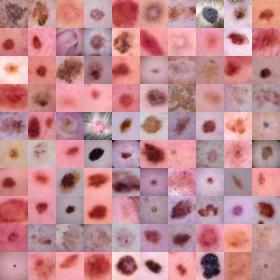

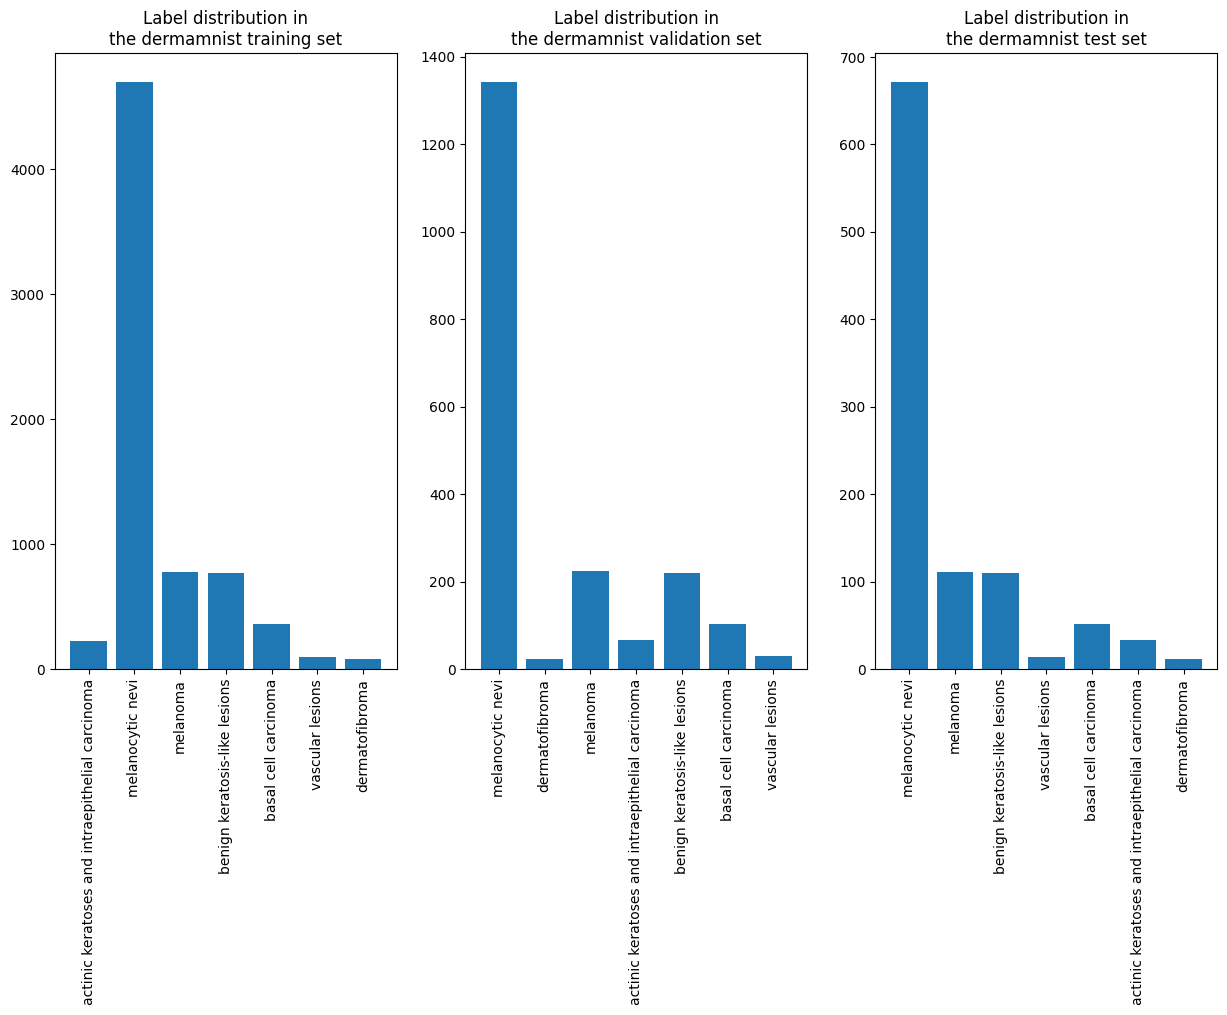

In [ ]:
dermamnist = import_dataset(
    "dermamnist", info_flags, print_visualization=True
)

## Обучение базового классификатора

{
  "python_class": "DermaMNIST",
  "description": "The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3\u00d7600\u00d7450 are resized into 3\u00d728\u00d728.",
  "url": "https://zenodo.org/record/6496656/files/dermamnist.npz?download=1",
  "MD5": "0744692d530f8e62ec473284d019b0c7",
  "task": "multi-class",
  "label": {
    "0": "actinic keratoses and intraepithelial carcinoma",
    "1": "basal cell carcinoma",
    "2": "benign keratosis-like lesions",
    "3": "dermatofibroma",
    "4": "melanoma",
    "5": "melanocytic nevi",
    "6": "vascular lesions"
  },
  "n_channels": 3,
  "n_samples": {
    "train": 7007,
    "val": 1003,
    "test": 2005
  },
  "license": "CC B

100%|██████████| 110/110 [00:09<00:00, 11.77it/s]


train -- accuracy: 0.6396
val -- accuracy: 0.669,  AUC: 0.8224
Epoch 1



100%|██████████| 110/110 [00:09<00:00, 11.14it/s]


train -- accuracy: 0.6699
val -- accuracy: 0.673,  AUC: 0.8582
Epoch 2



100%|██████████| 110/110 [00:05<00:00, 21.31it/s]


train -- accuracy: 0.6837
val -- accuracy: 0.676,  AUC: 0.8781
Epoch 3



100%|██████████| 110/110 [00:03<00:00, 30.75it/s]


train -- accuracy: 0.7042
val -- accuracy: 0.7139,  AUC: 0.8727
Epoch 4



100%|██████████| 110/110 [00:02<00:00, 39.56it/s]


train -- accuracy: 0.7139
val -- accuracy: 0.7228,  AUC: 0.8799
Epoch 5



100%|██████████| 110/110 [00:03<00:00, 29.48it/s]


train -- accuracy: 0.7201
val -- accuracy: 0.7288,  AUC: 0.8876
Epoch 6



100%|██████████| 110/110 [00:07<00:00, 14.41it/s]


train -- accuracy: 0.732
val -- accuracy: 0.7318,  AUC: 0.8981
Epoch 7



100%|██████████| 110/110 [00:02<00:00, 49.90it/s]


train -- accuracy: 0.73
val -- accuracy: 0.7208,  AUC: 0.8988
Epoch 8



100%|██████████| 110/110 [00:02<00:00, 51.55it/s]


train -- accuracy: 0.7415
val -- accuracy: 0.7139,  AUC: 0.8972
Epoch 9



100%|██████████| 110/110 [00:02<00:00, 53.45it/s]


train -- accuracy: 0.7395
val -- accuracy: 0.7328,  AUC: 0.8997
Epoch 10



100%|██████████| 110/110 [00:02<00:00, 45.45it/s]


train -- accuracy: 0.751
val -- accuracy: 0.7328,  AUC: 0.9063
Epoch 11



100%|██████████| 110/110 [00:02<00:00, 42.84it/s]


train -- accuracy: 0.7531
val -- accuracy: 0.7338,  AUC: 0.9109
Epoch 12



100%|██████████| 110/110 [00:02<00:00, 52.61it/s]


train -- accuracy: 0.7694
val -- accuracy: 0.7358,  AUC: 0.9105
Epoch 13



100%|██████████| 110/110 [00:02<00:00, 51.22it/s]


train -- accuracy: 0.7745
val -- accuracy: 0.7428,  AUC: 0.9155
Epoch 14



100%|██████████| 110/110 [00:02<00:00, 52.93it/s]


train -- accuracy: 0.7825
val -- accuracy: 0.7348,  AUC: 0.9142
Epoch 15



100%|██████████| 110/110 [00:02<00:00, 45.95it/s]


train -- accuracy: 0.7961
val -- accuracy: 0.7288,  AUC: 0.9151
Epoch 16



100%|██████████| 110/110 [00:02<00:00, 40.83it/s]


train -- accuracy: 0.8098
val -- accuracy: 0.7368,  AUC: 0.9188
Epoch 17



100%|██████████| 110/110 [00:02<00:00, 52.08it/s]


train -- accuracy: 0.8092
val -- accuracy: 0.7288,  AUC: 0.9124
Epoch 18



100%|██████████| 110/110 [00:02<00:00, 50.26it/s]


train -- accuracy: 0.8245
val -- accuracy: 0.7029,  AUC: 0.9074
Epoch 19



100%|██████████| 110/110 [00:02<00:00, 50.86it/s]


train -- accuracy: 0.8406
val -- accuracy: 0.6979,  AUC: 0.9077
test -- accuracy: 0.6953,  AUC: 0.896


<Figure size 1000x1000 with 0 Axes>

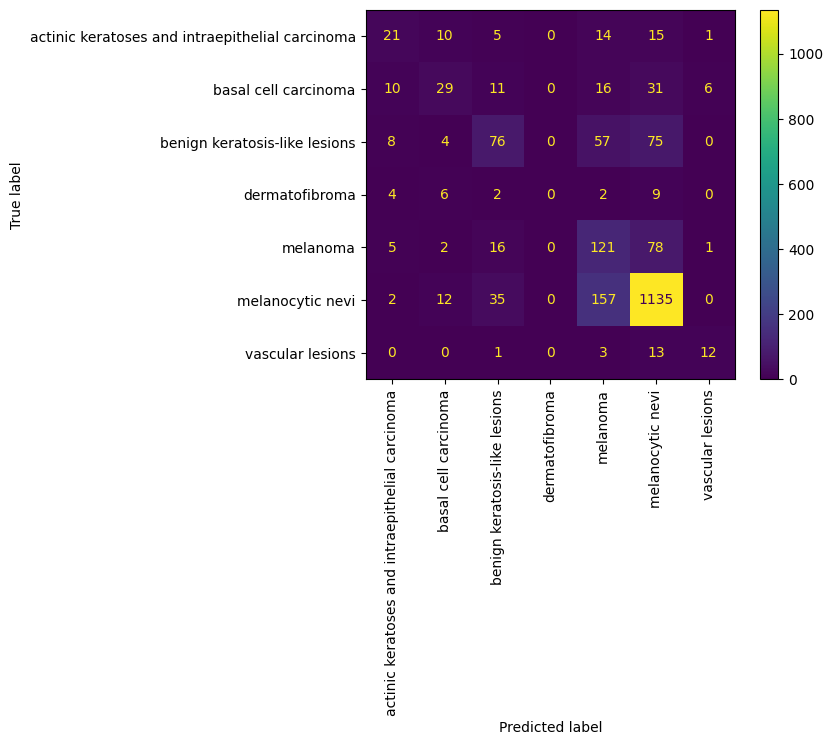

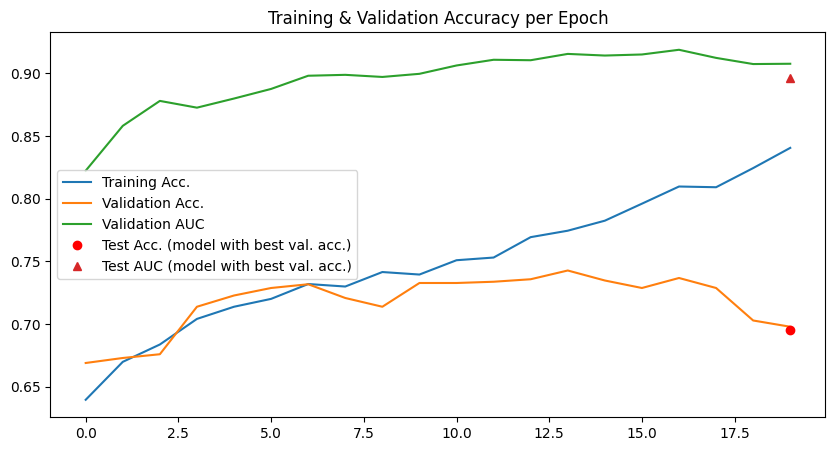

In [ ]:
clf = run_classifier_pipeline(
    "dermamnist", info_flags, dermamnist
)

## Создание синтетических данных

In [ ]:
# Declares the Conditional VAE's hyperparameters
latent_dims = 150
epochs = 200

In [ ]:
# Declares the dataset name and retrieves the base dataset
name_dataset = "dermamnist"
base_dataset = dermamnist

# Retrieves the dataset parameters
n_classes  = len(info_flags[name_dataset][0]["label"])
n_channels = info_flags[name_dataset][0]["n_channels"]

# Retrieves the data loader
train_loader = base_dataset[3]
val_loader = base_dataset[5]
test_loader = base_dataset[4]

Testing Conditional Variational Autoencoder:
Clearing CUDA Pytorch Cache
Model Output size: torch.Size([10, 3, 28, 28])
Forward pass test:  True
{'loss': tensor(25843.0488, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(25842.9492, grad_fn=<MseLossBackward0>), 'KLD': tensor(-20.0748, grad_fn=<NegBackward0>)}
Loss test:  True
Cuda device:  cuda
Training phase:
Train epoch 1 -- average loss: 104.28140024038461
Validation set loss: 64.746097
Train epoch 2 -- average loss: 43.69569567918131
Validation set loss: 28.942918
Train epoch 3 -- average loss: 31.388913480841147
Validation set loss: 37.689347
Train epoch 4 -- average loss: 28.35695583190526
Validation set loss: 25.597311
Train epoch 5 -- average loss: 26.15833457662594
Validation set loss: 22.280928
Train epoch 6 -- average loss: 24.6822972124137
Validation set loss: 21.230315
Train epoch 7 -- average loss: 23.584571007605675
Validation set loss: 21.309371
Train epoch 8 -- average loss: 21.13132439895484
Validation set loss

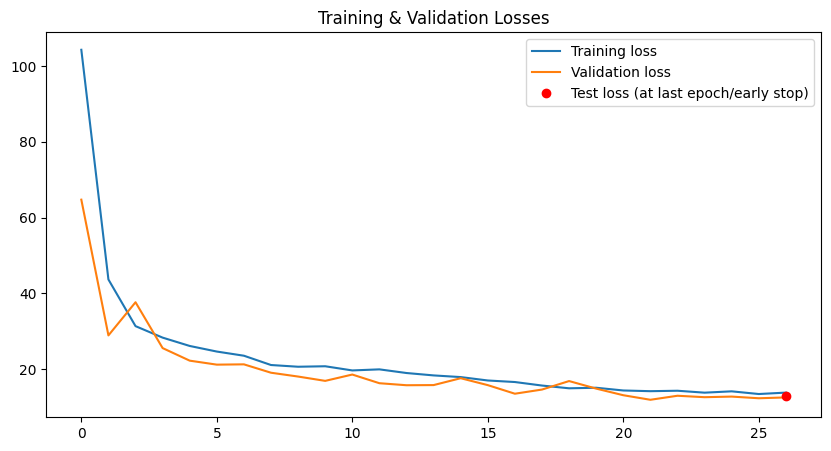

In [ ]:
# Runs the conditional VAE
_, _, _, _ = run_encoder_pipeline(
    train_loader, val_loader, test_loader, n_channels, latent_dims,
    n_classes=n_classes, epochs=epochs, name_dataset=name_dataset,
    output_intermediary_info=False, model_type="CondVAE"
)

## Обучение классфикатора на синтетических данных

In [ ]:
# Fetches the generated VAE Model model to import
model_path = f"trained_models/CondVAE/{name_dataset}/"
model = [x for x in os.listdir(model_path) if x[-4:]==".pth"][-1]
model_path += model

# Calculates the number of images to generate
percentage = 10
nb_images_in_dataset = len(base_dataset[0])
n_generated_images = int((percentage/100)*nb_images_in_dataset)
print(f"Number of generated images: {n_generated_images}",
      f"({percentage}% of the dataset)")

# Creates the synthetic dataloader
condVAE_loader = generate_synthetic_dataset_condVAE(
    n_channels, n_classes, latent_dims, model_path,
    base_dataset[0], 64, test_loader, val_loader,
    n_generated_images, weighted_sampling=False
)

Number of generated images: 700 (10% of the dataset)


Оценим качество на синтетических данных

{
  "python_class": "DermaMNIST",
  "description": "The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3\u00d7600\u00d7450 are resized into 3\u00d728\u00d728.",
  "url": "https://zenodo.org/record/6496656/files/dermamnist.npz?download=1",
  "MD5": "0744692d530f8e62ec473284d019b0c7",
  "task": "multi-class",
  "label": {
    "0": "actinic keratoses and intraepithelial carcinoma",
    "1": "basal cell carcinoma",
    "2": "benign keratosis-like lesions",
    "3": "dermatofibroma",
    "4": "melanoma",
    "5": "melanocytic nevi",
    "6": "vascular lesions"
  },
  "n_channels": 3,
  "n_samples": {
    "train": 7007,
    "val": 1003,
    "test": 2005
  },
  "license": "CC B

100%|██████████| 11/11 [00:00<00:00, 100.61it/s]

train -- accuracy: 0.1386


val -- accuracy: 0.669,  AUC: 0.4524
Epoch 1



100%|██████████| 11/11 [00:00<00:00, 131.76it/s]

train -- accuracy: 0.1557


val -- accuracy: 0.665,  AUC: 0.427
Epoch 2



100%|██████████| 11/11 [00:00<00:00, 129.74it/s]

train -- accuracy: 0.1686


val -- accuracy: 0.6251,  AUC: 0.5495
Epoch 3



100%|██████████| 11/11 [00:00<00:00, 168.26it/s]

train -- accuracy: 0.1871


val -- accuracy: 0.5833,  AUC: 0.6629
Epoch 4



100%|██████████| 11/11 [00:00<00:00, 181.74it/s]

train -- accuracy: 0.2243


val -- accuracy: 0.5503,  AUC: 0.7026
Epoch 5



100%|██████████| 11/11 [00:00<00:00, 184.37it/s]

train -- accuracy: 0.2457


val -- accuracy: 0.6072,  AUC: 0.7215
Epoch 6



100%|██████████| 11/11 [00:00<00:00, 178.22it/s]

train -- accuracy: 0.27


val -- accuracy: 0.5743,  AUC: 0.7282
Epoch 7



100%|██████████| 11/11 [00:00<00:00, 173.48it/s]

train -- accuracy: 0.2943


val -- accuracy: 0.5862,  AUC: 0.7392
Epoch 8



100%|██████████| 11/11 [00:00<00:00, 180.05it/s]

train -- accuracy: 0.3014


val -- accuracy: 0.5444,  AUC: 0.7368
Epoch 9



100%|██████████| 11/11 [00:00<00:00, 180.47it/s]

train -- accuracy: 0.3029


val -- accuracy: 0.5503,  AUC: 0.7413
Epoch 10



100%|██████████| 11/11 [00:00<00:00, 171.22it/s]

train -- accuracy: 0.3129


val -- accuracy: 0.5095,  AUC: 0.743
Epoch 11



100%|██████████| 11/11 [00:00<00:00, 158.98it/s]

train -- accuracy: 0.3214


val -- accuracy: 0.4826,  AUC: 0.7479
Epoch 12



100%|██████████| 11/11 [00:00<00:00, 183.90it/s]

train -- accuracy: 0.3257


val -- accuracy: 0.4676,  AUC: 0.7488
Epoch 13



100%|██████████| 11/11 [00:00<00:00, 174.98it/s]

train -- accuracy: 0.3357


val -- accuracy: 0.4367,  AUC: 0.7479
Epoch 14



100%|██████████| 11/11 [00:00<00:00, 173.71it/s]

train -- accuracy: 0.3243


val -- accuracy: 0.4397,  AUC: 0.7499
Epoch 15



100%|██████████| 11/11 [00:00<00:00, 161.81it/s]

train -- accuracy: 0.3471


val -- accuracy: 0.4536,  AUC: 0.7559
Epoch 16



100%|██████████| 11/11 [00:00<00:00, 164.27it/s]

train -- accuracy: 0.3557


val -- accuracy: 0.4098,  AUC: 0.7519
Epoch 17



100%|██████████| 11/11 [00:00<00:00, 184.50it/s]

train -- accuracy: 0.3557


val -- accuracy: 0.4177,  AUC: 0.7588
Epoch 18



100%|██████████| 11/11 [00:00<00:00, 174.19it/s]

train -- accuracy: 0.3586


val -- accuracy: 0.3799,  AUC: 0.748
Epoch 19



100%|██████████| 11/11 [00:00<00:00, 180.59it/s]

train -- accuracy: 0.3714


val -- accuracy: 0.4008,  AUC: 0.7571
test -- accuracy: 0.416,  AUC: 0.7508


<Figure size 1000x1000 with 0 Axes>

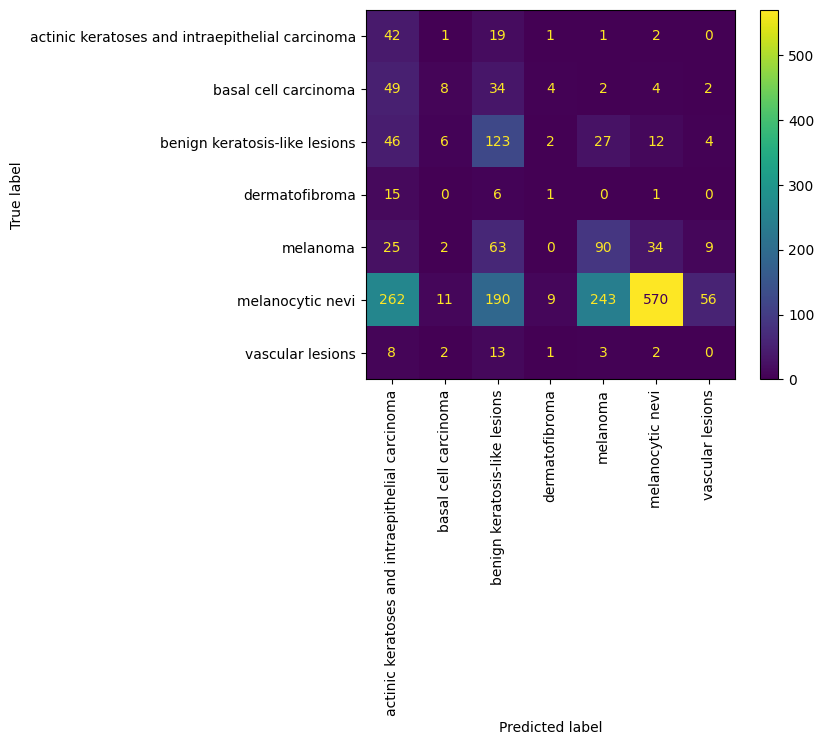

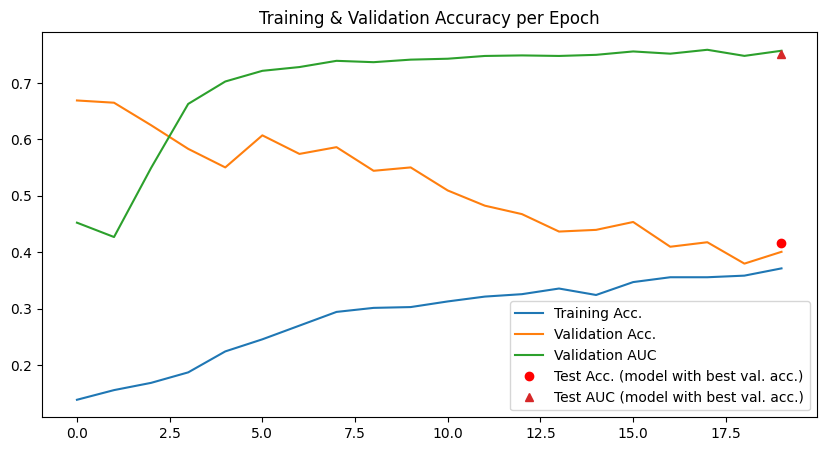

In [ ]:
# Runs the classifier again
clf = run_classifier_pipeline(name_dataset, info_flags, condVAE_loader)